# Import dependencies

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV,
)
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_squared_error,
    precision_score, 
    recall_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold, 
    GridSearchCV
)

# Import cleaned data

In [2]:
df = pd.read_csv("summer_men_swimming.csv", index_col=0)

In [3]:
df.head()

,Name,Age,Height,Weight,NOC,Year,City,Sport,Event,Medal,Times_Participated,Participation_Number
29,"Einar Ferdinand ""Einari"" Aalto",26.0,182.850556,76.743311,FIN,1952,Helsinki,Swimming,Swimming Men's 400 metres Freestyle,no medal,1,1
35,Arvo Ossian Aaltonen,22.0,182.008432,76.694056,FIN,1912,Stockholm,Swimming,Swimming Men's 200 metres Breaststroke,no medal,3,1
36,Arvo Ossian Aaltonen,22.0,177.000000,75.000000,FIN,1912,Stockholm,Swimming,Swimming Men's 400 metres Breaststroke,no medal,3,1
37,Arvo Ossian Aaltonen,30.0,182.008432,76.694056,FIN,1920,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze,3,2
38,Arvo Ossian Aaltonen,30.0,177.000000,75.000000,FIN,1920,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze,3,2


In [4]:
df.shape

(12506, 12)

In [5]:
df.isna().sum()

Name                    0
Age                     0
Height                  0
Weight                  0
NOC                     0
Year                    0
City                    0
Sport                   0
Event                   0
Medal                   0
Times_Participated      0
Participation_Number    0
dtype: int64

In [6]:
# For binary classification 
df["Medal_Binary"] = df["Medal"].apply(lambda x: "medal" if x != "no medal" else "no medal")

## Preprocessing

### Split data into train and test

In [7]:
X = df.drop(columns=["Medal", "Medal_Binary","Name", "Sport"])
y_multi = df["Medal"]
y_binary = (df["Medal"] != "no medal").astype(int)


In [8]:
print(y_multi.value_counts())
print("\nRelative frequencies:")
print(y_multi.value_counts(normalize=True))

Medal
no medal    11025
Gold          572
Bronze        455
Silver        454
Name: count, dtype: int64

Relative frequencies:
Medal
no medal    0.881577
Gold        0.045738
Bronze      0.036383
Silver      0.036303
Name: proportion, dtype: float64


In [9]:
print(y_binary.value_counts())
print("\nRelative frequencies:")
print(y_binary.value_counts(normalize=True))

Medal
0    11025
1     1481
Name: count, dtype: int64

Relative frequencies:
Medal
0    0.881577
1    0.118423
Name: proportion, dtype: float64


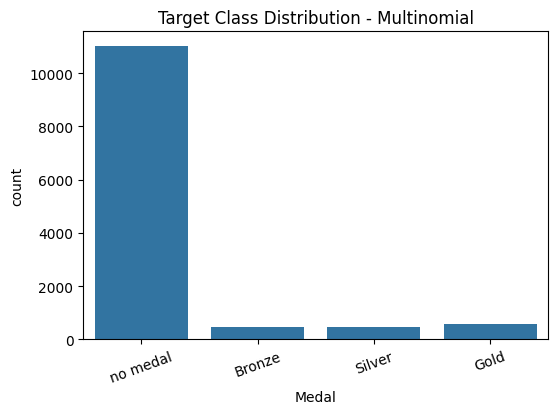

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_multi)
plt.title("Target Class Distribution - Multinomial")
plt.xticks(rotation=20)
plt.show()

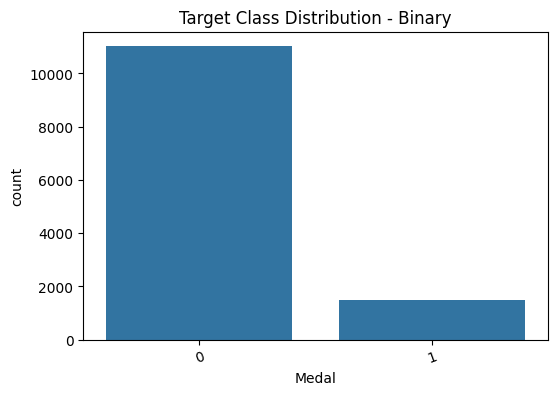

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_binary)
plt.title("Target Class Distribution - Binary")
plt.xticks(rotation=20)
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=55, stratify=y_multi)       # test size 0.1 because I have a large dataset and i want to train on as much data as possible
print(X_train.shape, X_test.shape)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_binary, test_size=0.2, random_state=55, stratify=y_binary)       # test size 0.1 because I have a large dataset and i want to train on as much data as possible
print(X_train_b.shape, X_test_b.shape)

(10004, 9) (2502, 9)
(10004, 9) (2502, 9)


### Separate categorical and numerical features

In [13]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

categorical_features, numeric_features

(['NOC', 'City', 'Event'],
 ['Age',
  'Height',
  'Weight',
  'Year',
  'Times_Participated',
  'Participation_Number'])

### Define transformers pipelines

In [14]:
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore", feature_name_combiner="concat").set_output(transform="pandas"))])
categorical_transformer

,steps,"[('onehot', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [15]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler().set_output(transform="pandas"))])
numeric_transformer

,steps,"[('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True


In [16]:
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer, categorical_features)
                                               ]).set_output(transform="pandas")
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


## Models

### Create a dataframe to keep scores

In [17]:
def evaluate_model(y_test, y_pred, model_name, results_df):
    report = classification_report(y_test, y_pred, output_dict=True)

    new_row = {
        "model_name": model_name,
        "Macro_F1": report["macro avg"]["f1-score"],
        "Macro_Recall": report["macro avg"]["recall"],
        "Macro_Precision": report["macro avg"]["precision"]
    }

    return pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


### Train and evaluate different models

#### MultiClass Models

In [18]:

multiclass_models = {
    "LogReg_mc": LogisticRegression(solver="lbfgs", max_iter=500
    ),
    "RF_mc": RandomForestClassifier(),
    "SVM_mc": LinearSVC(),
    "LGBM_mc": LGBMClassifier(),
    "GB_mc": GradientBoostingClassifier(),
    "Adaboost_mc": AdaBoostClassifier(),
    "DecisionTreeClassifier_mc": DecisionTreeClassifier(),
    "NB_mc": BernoulliNB()
}


#### Binary Models

In [19]:
binary_models = {
    "LogReg_bin": LogisticRegression(max_iter=500, class_weight="balanced"),
    "RF_bin": RandomForestClassifier(),
    "SVM_bin": LinearSVC(),
    "LGBM_bin": LGBMClassifier(),
    "GB_bin": GradientBoostingClassifier(),
    "Adaboost_bin": AdaBoostClassifier(),
    "DecisionTreeClassifier_bin": DecisionTreeClassifier(),
    "NB_bin": BernoulliNB()
}


In [20]:
from sklearn.preprocessing import FunctionTransformer
import re

def clean_feature_names(X):
    X.columns = X.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)
    return X

cleaner = FunctionTransformer(clean_feature_names)

### Cross-Validation Function

In [21]:
def evaluate_models(models, X_train, y_train, scoring):
    results = []

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():

        pipe = Pipeline([
            ("prep", preprocessor),
            ("clean_names", cleaner),
            ("model", model)
        ])

        scores = cross_val_score(pipe, X_train, y_train, 
                                 cv=cv, scoring=scoring, n_jobs=-1)

        results.append({
            "Model": name,
            "CV_" + scoring: scores.mean().round(4)
        })

    return pd.DataFrame(results).sort_values(by="CV_" + scoring, ascending=False)


### Evaluation of Models

In [22]:
# Multiclass
mc_results = evaluate_models(multiclass_models, X_train, y_train, scoring="f1_macro")
mc_results


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 8003, number of used features: 119
[LightGBM] [Info] Start training from score -3.314248
[LightGBM] [Info] Start training from score -3.084938
[LightGBM] [Info] Start training from score -3.314248
[LightGBM] [Info] Start training from score -0.126080
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Number of data points in the train set: 8003, number of us

,Model,CV_f1_macro
6,DecisionTreeClassifier_mc,0.5815
3,LGBM_mc,0.4957
1,RF_mc,0.4953
4,GB_mc,0.4414
0,LogReg_mc,0.3891
2,SVM_mc,0.3860
7,NB_mc,0.3827
5,Adaboost_mc,0.3612


In [23]:
# Binary 
bin_results = evaluate_models(binary_models, X_train_b, y_train_b, scoring="f1_macro")
bin_results

[LightGBM] [Info] Number of positive: 948, number of negative: 7055
[LightGBM] [Info] Number of positive: 948, number of negative: 7055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 8003, number of used features: 118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118456 -> initscore=-2.007137
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Start training from score -2.007137
[LightGBM] [Info] Number of data points in the train set: 8003, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118456 -> initscore=-2.007137
[LightGBM]

,Model,CV_f1_macro
6,DecisionTreeClassifier_bin,0.7984
3,LGBM_bin,0.7915
1,RF_bin,0.7826
4,GB_bin,0.7585
7,NB_bin,0.7410
2,SVM_bin,0.7364
5,Adaboost_bin,0.7174
0,LogReg_bin,0.6967


In [27]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, make_scorer)

def evaluate_models(models, X_train, y_train, scoring):
    results = []

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score, average="weighted", zero_division=0),
        "recall": make_scorer(recall_score, average="weighted", zero_division=0),
        "f1": make_scorer(f1_score, average="weighted", zero_division=0),
    }

    for name, model in models.items():

        pipe = Pipeline([
            ("prep", preprocessor),
            ("clean_names", cleaner),
            ("model", model)
        ])

        cv_results = cross_validate(
            pipe,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1,
        )
        record = {"Model": name}
        # For each metric compute mean and std
        for metric in scoring.keys():
            scores = cv_results[f"test_{metric}"]
            record[f"{metric}_mean"] = float(np.mean(scores))
            record[f"{metric}_std"] = float(np.std(scores))
        results.append(record)

        results_df = pd.DataFrame(results)
        # Order columns for readability
        ordered_columns = [
            "Model",
            "accuracy_mean", "accuracy_std",
            "precision_mean", "precision_std",
            "recall_mean", "recall_std",
            "f1_mean", "f1_std",
        ]
        results_df = results_df[ordered_columns]
        # Sort by F1 mean descending (as a general indicator)
        results_df = results_df.sort_values(by="f1_mean", ascending=False).reset_index(drop=True)
    return results_df


In [28]:
bin_results = evaluate_models(binary_models, X_train_b, y_train_b, scoring="f1_macro")
bin_results

[LightGBM] [Info] Number of positive: 948, number of negative: 7055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 8003, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118456 -> initscore=-2.007137
[LightGBM] [Info] Start training from score -2.007137
[LightGBM] [Info] Number of positive: 948, number of negative: 7055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 8003, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118456 -> initscore=-2.007137
[LightGBM]

,Model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,LGBM_bin,0.926629,0.002094,0.920772,0.002366,0.926629,0.002094,0.919579,0.003581
1,RF_bin,0.925530,0.002693,0.920072,0.003993,0.925530,0.002693,0.916674,0.002515
2,DecisionTreeClassifier_bin,0.913635,0.005008,0.914593,0.005049,0.913635,0.005008,0.914053,0.004948
3,GB_bin,0.921331,0.001748,0.915579,0.002579,0.921331,0.001748,0.909918,0.001970
4,NB_bin,0.906338,0.002953,0.896332,0.003532,0.906338,0.002953,0.898910,0.003159
5,SVM_bin,0.907938,0.005690,0.897340,0.006889,0.907938,0.005690,0.898672,0.005308
6,Adaboost_bin,0.906637,0.004765,0.894559,0.006773,0.906637,0.004765,0.893858,0.005303
7,LogReg_bin,0.814475,0.009804,0.898281,0.002481,0.814475,0.009804,0.840891,0.007278


## Hyperparameter tuning

We choose the binary classification models for hyperparameter tuning since they provide the best performance. LGBM_binary and Decision tree Classifier binary. The multi class models are not performing very well. Therefore, I will not use them. 

In [29]:
def compute_scale_pos_weight(y: pd.Series) -> float:
    """Compute the scale_pos_weight for LightGBM.

    The scale_pos_weight is defined as the ratio of the number of negative
    samples to the number of positive samples. It can improve the
    performance of LightGBM on imbalanced binary classification problems.

    Parameters
    ----------
    y : pd.Series
        Target vector with two classes 0 and 1. The minority class should be
        encoded as 1.

    Returns
    -------
    float
        The scale_pos_weight value.
    """
    classes, counts = np.unique(y, return_counts=True)
    if len(classes) != 2:
        return 1.0
    # identify positive (minority) class
    pos_class = classes[np.argmin(counts)]
    neg_class = classes[np.argmax(counts)]
    n_pos = counts[np.argmin(counts)]
    n_neg = counts[np.argmax(counts)]
    return float(n_neg / n_pos)

In [30]:
compute_scale_pos_weight(y_train_b)

7.4421940928270045

In [33]:
from typing import Tuple, Dict, List
from typing import Tuple, Dict, Any
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(y: pd.Series) -> Dict[Any, float]:
    """Compute class weights as a dictionary for use in Scikit‑learn classifiers.

    Parameters
    ----------
    y : pd.Series
        Target vector.

    Returns
    -------
    dict
        A mapping from class label to weight.
    """
    classes = np.unique(y)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    return {cls: weight for cls, weight in zip(classes, weights)}

In [35]:
class_weights = get_class_weights(y_train_b)

In [39]:
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

spaces = {}

# ----------------------------
# 1. LightGBM
# ----------------------------
lgbm_clf = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    random_state=42
)

lgbm_param_dist = {
    "model__num_leaves": [31, 63, 127],
    "model__max_depth": [-1, 5, 10, 15],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__n_estimators": [100, 200, 500],
    "model__min_child_samples": [10, 20, 50, 100],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__reg_alpha": [0.0, 0.1, 0.5],
    "model__reg_lambda": [0.0, 0.1, 1.0],
    "model__is_unbalance": [True, False]
}

spaces["LightGBM"] = {
    "estimator": Pipeline([("preprocess", preprocessor),
                           ("clean_names", cleaner),
                           ("model", lgbm_clf)]),
    "param_dist": lgbm_param_dist
}


# ----------------------------
# 2. Decision Tree
# ----------------------------
dt_clf = DecisionTreeClassifier(random_state=42)

dt_param_dist = {
    "model__max_depth": [None, 5, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 6],
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__class_weight": [None, class_weights, "balanced"]
}

spaces["DecisionTree"] = {
    "estimator": Pipeline([("preprocess", preprocessor),
                           ("model", dt_clf)]),
    "param_dist": dt_param_dist
}


# ----------------------------
# 3. Random Forest
# ----------------------------
rf_clf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_param_dist = {
    "model__n_estimators": [100, 200, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
    "model__bootstrap": [True, False],
    "model__class_weight": [None, class_weights, "balanced"]
}

spaces["RandomForest"] = {
    "estimator": Pipeline([("preprocess", preprocessor),
                           ("model", rf_clf)]),
    "param_dist": rf_param_dist
}


# ----------------------------
# 4. Support Vector Machine
# ----------------------------
svc_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", SVC(probability=False))
])

svc_param_dist = {
    "model__C": [0.1, 1, 10, 100],
    "model__gamma": ["scale", "auto", 0.01, 0.1, 1],
    "model__kernel": ["rbf", "poly", "sigmoid"],
    "model__class_weight": [None, class_weights, "balanced"]
}

spaces["SVC"] = {
    "estimator": svc_pipe,
    "param_dist": svc_param_dist
}


In [43]:
spaces

{'LightGBM': {'estimator': Pipeline(steps=[('preprocess',
                   ColumnTransformer(transformers=[('num',
                                                    Pipeline(steps=[('scaler',
                                                                     StandardScaler())]),
                                                    ['Age', 'Height', 'Weight',
                                                     'Year', 'Times_Participated',
                                                     'Participation_Number']),
                                                   ('cat',
                                                    Pipeline(steps=[('onehot',
                                                                     OneHotEncoder(handle_unknown='ignore',
                                                                                   sparse_output=False))]),
                                                    ['NOC', 'City', 'Event'])])),
                  ('clean_names',
  

In [40]:
model_name = "LightGBM"

search = RandomizedSearchCV(
    estimator=spaces[model_name]["estimator"],
    param_distributions=spaces[model_name]["param_dist"],
    scoring="f1",
    cv=5,
    n_iter=30,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train_b, y_train_b)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 948, number of negative: 7055
[LightGBM] [Info] Number of positive: 948, number of negative: 7055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 8003, number of used features: 118
[LightGBM] [Info] Number of data points in the train set: 8003, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118456 -> initscore=-2.007137
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118456 -> initscore=-2.007137
[LightGBM] [Info] Start training from score -2.007137
[LightGBM] [

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__colsample_bytree': [0.6, 0.8, ...], 'model__is_unbalance': [True, False], 'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [-1, 5, ...], ...}"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
def run_search(model_name, estimator, param_dist, X_train, y_train, cv=5, n_iter=20):
    print(f"\n🔍 Searching best params for: {model_name}")

    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        scoring="f1",
        n_iter=n_iter,
        cv=cv,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)

    print(f"➡️ Best F1 Score: {search.best_score_:.4f}")
    print(f"➡️ Best Params: {search.best_params_}")

    return search


In [44]:
from tqdm import tqdm
results = []
best_models = {}

for model_name, cfg in tqdm(spaces.items()):
    estimator = cfg["estimator"]
    param_dist = cfg["param_dist"]

    search = run_search(model_name, estimator, param_dist,
                        X_train_b, y_train_b, cv=5, n_iter=20)

    best_models[model_name] = search.best_estimator_

    results.append({
        "model": model_name,
        "best_f1_cv": search.best_score_,
        "best_params": search.best_params_
    })

results_df = pd.DataFrame(results).sort_values("best_f1_cv", ascending=False)
results_df

  0%|          | 0/4 [00:00<?, ?it/s]


🔍 Searching best params for: LightGBM
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 948, number of negative: 7055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8003, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118456 -> initscore=-2.007137
[LightGBM] [Info] Start training from score -2.007137
[LightGBM] [Info] Number of positive: 948, number of negative: 7055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of positive: 948, number of negative: 7055
[LightGBM] [Info] Number of data points in the train set: 8003, number of used

 25%|██▌       | 1/4 [01:05<03:16, 65.51s/it]

➡️ Best F1 Score: 0.6745
➡️ Best Params: {'model__subsample': 1.0, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0.0, 'model__num_leaves': 63, 'model__n_estimators': 100, 'model__min_child_samples': 10, 'model__max_depth': 15, 'model__learning_rate': 0.2, 'model__is_unbalance': True, 'model__colsample_bytree': 1.0}

🔍 Searching best params for: DecisionTree
Fitting 5 folds for each of 20 candidates, totalling 100 fits


 50%|█████     | 2/4 [01:07<00:55, 27.88s/it]

➡️ Best F1 Score: 0.6526
➡️ Best Params: {'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 30, 'model__criterion': 'gini', 'model__class_weight': None}

🔍 Searching best params for: RandomForest
Fitting 5 folds for each of 20 candidates, totalling 100 fits


 75%|███████▌  | 3/4 [02:51<01:02, 62.79s/it]

➡️ Best F1 Score: 0.6599
➡️ Best Params: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': 20, 'model__class_weight': None, 'model__bootstrap': True}

🔍 Searching best params for: SVC
Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 4/4 [04:50<00:00, 72.55s/it]

➡️ Best F1 Score: 0.6248
➡️ Best Params: {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__class_weight': {np.int64(0): np.float64(0.5671844880371925), np.int64(1): np.float64(4.221097046413502)}, 'model__C': 100}


,model,best_f1_cv,best_params
0,LightGBM,0.674451,"{'model__subsample': 1.0, 'model__reg_lambda':..."
2,RandomForest,0.659902,"{'model__n_estimators': 200, 'model__min_sampl..."
1,DecisionTree,0.652611,"{'model__min_samples_split': 5, 'model__min_sa..."
3,SVC,0.624795,"{'model__kernel': 'rbf', 'model__gamma': 0.1, ..."


In [ ]:
best_model_name = results_df.iloc[0]["model"]
best_model = best_models[best_model_name]

print(f"BEST MODEL: {best_model_name}")
best_model


🏆 BEST MODEL: LightGBM


,steps,"[('preprocess', ...), ('clean_names', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
y_pred = best_model.predict(X_test_b)

test_results = {
    "accuracy": accuracy_score(y_test_b, y_pred),
    "precision": precision_score(y_test_b, y_pred),
    "recall": recall_score(y_test_b, y_pred),
    "f1": f1_score(y_test_b, y_pred)
}

print("Test Set Evaluation:")
for k, v in test_results.items():
    print(f"{k:10} : {v:.4f}")

print("Classification Report:")
print(classification_report(y_test_b, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_b, y_pred))


Test Set Evaluation:
accuracy   : 0.9213
precision  : 0.6523
recall     : 0.7162
f1         : 0.6828
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2206
           1       0.65      0.72      0.68       296

    accuracy                           0.92      2502
   macro avg       0.81      0.83      0.82      2502
weighted avg       0.92      0.92      0.92      2502

Confusion Matrix:
[[2093  113]
 [  84  212]]


## Stacking classifier